In [ ]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.nn import Conv2d, ConvTranspose2d
from torch.utils import data
from torch import optim
from torchvision.transforms.functional import erase
from torch.nn.modules.activation import ReLU, LeakyReLU
from torchvision.transforms.functional import rotate

from random import sample
from tqdm import trange, tqdm
from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [7]:
def get_dataloader(data: np.ndarray, bs: int = 256):
    return torch.utils.data.DataLoader(dataset=data,
                                        shuffle=True,
                                        pin_memory=True,
                                        drop_last=False,
                                        num_workers=1,
                                        batch_size=bs)

In [61]:
class Encoder(torch.nn.Module):
      def __init__(self, **kwargs):
        super().__init__()
        self.model = torch.nn.Sequential(
            Conv2d(1, 32, 3, 1, 1),
            LeakyReLU(0.2),
            Conv2d(32, 64, 3, 2, 1),
            LeakyReLU(0.2),
            Conv2d(64, 128, 3, 2, 1),
            LeakyReLU(0.2),
            Conv2d(128, 128, 3, 2, 1),
            LeakyReLU(0.2)
        )
        self.linear = torch.nn.Linear(16 * 128, 128)
      
      def forward(self, x):
        output = self.model(x)  
        output = torch.flatten(output, start_dim=1)
        return self.linear(output) # bs, 128

In [9]:
class Decoder(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.linear = torch.nn.Linear(128, 128 * 4 * 4)

        self.model = torch.nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.LeakyReLU())
        
        self.conv_layer = Conv2d(64, 1, 3, 1, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        output = self.linear(x).reshape(x.shape[0], 128, 4, 4)
        output = self.model(output)
        output = self.conv_layer(output)
        return self.tanh(output) # bs, 1, 14, 14

In [10]:
class Classifier(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.model = torch.nn.Sequential(
            Conv2d(1, 32, 3, 1, 1),
            LeakyReLU(0.2),
            Conv2d(32, 64, 3, 2, 1),
            LeakyReLU(0.2),
            Conv2d(64, 128, 3, 2, 1),
            LeakyReLU(0.2), 
            Conv2d(128, 128, 3, 2, 1), 
            LeakyReLU(0.2))

        self.linears = torch.nn.Sequential(torch.nn.Linear(512, 128), 
                                           LeakyReLU(0.2), 
                                           torch.nn.Linear(128, 1), 
                                           torch.nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)  
        output = torch.flatten(output, start_dim=1)
        output = self.linears(output)
        return output # bs, 1

In [37]:
# encoder = Encoder()
# image = torch.unsqueeze(torch.ones(1, 28, 28), 0)
# embedding = encoder(image)
# embedding.shape

In [12]:
# decoder = Decoder()
# decoded_image = decoder(embedding)
# decoded_image.shape

torch.Size([1, 1, 14, 14])

In [13]:
# classifier = Classifier()
# classifier(decoded_image)

tensor([[0.5226]], grad_fn=<SigmoidBackward0>)

In [14]:
# classifier = nn.Linear(128, 4).to(device)
# classifier(embedding)

tensor([[ 0.0993, -0.0094,  0.0908,  0.0544]], grad_fn=<AddmmBackward0>)

In [188]:
class CE:
  def __init__(self):
      super().__init__()
      self.lr = 1e-4
      self.epochs = 20
      self.image_size = 28
      self.crop_size = 14
      self.lower_crop_broder = (self.image_size // 2) - (self.crop_size // 2)
      self.higher_crop_border = (self.image_size // 2) + (self.crop_size // 2)

      self.encoder = Encoder().to(device)
      self.decoder = Decoder().to(device)
      self.classifier = Classifier().to(device)

      self.main_optimizer = torch.optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()),
                                             lr=self.lr)
      self.clas_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=self.lr)


  def crop_batch(self, x: torch.tensor):
      return x[:, :, 
               self.lower_crop_broder:self.higher_crop_border, 
               self.lower_crop_broder:self.higher_crop_border]


  def get_mask(self):
      array = np.ones((self.image_size, self.image_size))
      array[self.lower_crop_broder:self.higher_crop_border, 
            self.lower_crop_broder:self.higher_crop_border] = 0
      return torch.tensor(array).long().unsqueeze(dim=0)


  def classifier_loss(self, real_images, reconstructed_images):
      true_predictions = self.classifier(real_images)
      false_predictions = self.classifier(reconstructed_images)
      real_loss = F.binary_cross_entropy(true_predictions, torch.ones_like(true_predictions))
      fake_loss = F.binary_cross_entropy(false_predictions, torch.zeros_like(false_predictions))
      return real_loss + fake_loss


  def adversarial_loss(self, reconstrictions, real_images):
      mse_loss = F.mse_loss(reconstrictions, real_images)
      with torch.no_grad():
            probabilities = self.classifier(reconstrictions)
            adv_loss = F.binary_cross_entropy(
                probabilities, torch.ones(
                    (reconstrictions.shape[0], 1), device=device))
      return mse_loss + adv_loss


  def sample(self, dataloader, flip: bool = False):
      with torch.no_grad():
          images = [i[0] for i in dataloader]
          real_images = images[0]
          real_images = real_images.to(device)

          mask = torch.cat([self.get_mask() for _ in range(10)], dim=0).unsqueeze(dim=1).to(device)
          encoded_images = self.encoder(real_images * mask)
          reconstructed_images = self.decoder(encoded_images)

          reconstractions = real_images.clone()
          reconstractions[:, :, self.lower_crop_broder:self.higher_crop_border, 
                          self.lower_crop_broder:self.higher_crop_border] = reconstructed_images

          masked_images = real_images * mask

          return [masked_images.detach().cpu().numpy(),
                  reconstractions.detach().cpu().numpy(),
                  real_images.detach().cpu().numpy()]


  def train_loop(self, train_loader, test_loader, flip: bool = False):
      self.encoder.train()
      self.decoder.train()
      self.classifier.train()

      train_losses = defaultdict(lambda: [])

      for epoch in trange(self.epochs):
        epoch_train_losses = defaultdict(lambda: [])

        for x, _ in train_loader:
            x = x.to(device)

            # discriminator loss
            if epoch % 5 == 0:
                with torch.no_grad():
                    M = torch.cat([self.get_mask() for _ in range(x.shape[0])], 
                                  dim=0).unsqueeze(dim=1).to(device) 

                    masked_images = x * M
                    encoded_images = self.encoder(masked_images)
                    reconstructions = self.decoder(encoded_images)
                real_images_cropped = self.crop_batch(x)

                classifier_loss = self.classifier_loss(real_images_cropped, 
                                                       reconstructions)
                
                self.clas_optimizer.zero_grad()
                classifier_loss.backward()
                self.clas_optimizer.step()
                epoch_train_losses["cl_loss"].append(classifier_loss.item())

            # adversarial loss
            M = torch.cat([self.get_mask() for _ in range(x.shape[0])], 
                          dim=0).unsqueeze(dim=1).to(device) 
            masked_images = x * M
            encoded_images = self.encoder(masked_images)
            reconstructions = self.decoder(encoded_images)
            real_cropped_images = self.crop_batch(x)

            adversarial_loss = self.adversarial_loss(reconstructions, 
                                                     real_cropped_images)
            
            self.main_optimizer.zero_grad()
            adversarial_loss.backward()
            self.main_optimizer.step()
            epoch_train_losses["main_loss"].append(adversarial_loss.item())

        for k in epoch_train_losses.keys():
          train_losses[k].append(np.mean(epoch_train_losses[k]))

      samples = self.sample(test_loader)
      return train_losses, samples

In [189]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """

    train_loader = get_dataloader(train_data, bs=512)
    test_loader = get_dataloader(test_data, bs=10)

    ce = CE()

    train_losses, samples = ce.train_loop(train_loader, test_loader)
    samples = np.array(samples).reshape(30, 1, 28, 28)
    
    return train_losses["cl_loss"], train_losses["main_loss"], samples

100%|██████████| 20/20 [08:03<00:00, 24.16s/it]


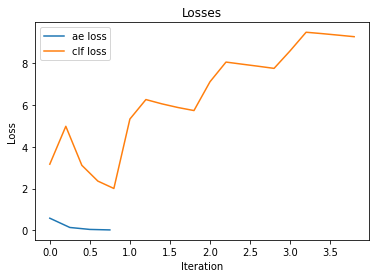

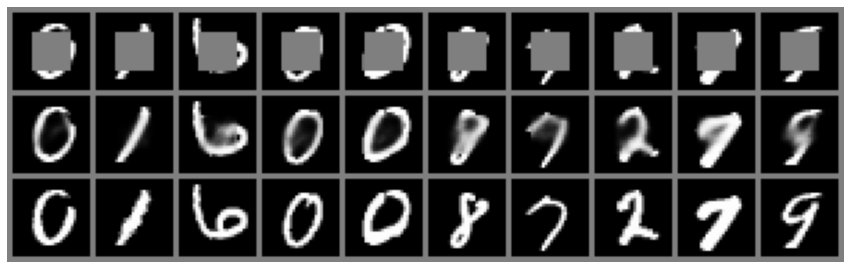

In [190]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [66]:
class Dataset(data.Dataset):
    def __init__(self, data) -> None:
        super().__init__()

        self.data = data
        self.rotations = [0, 90, 180, 270]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        angle_idx = np.random.choice(len(self.rotations))
        return rotate(self.data[index][0], self.rotations[angle_idx]), angle_idx

In [67]:
class RotationCE:
    def __init__(self):
        super().__init__()

        self.lr = 1e-2
        self.epochs = 1
        self.rotations = [0, 90, 180, 270]

        self.encoder = Encoder().to(device)
        self.classifier = nn.Sequential(LeakyReLU(0.2),    
                                        nn.Linear(128, 128).to(device),
                                        LeakyReLU(0.2),    
                                        nn.Linear(128, 4).to(device))
        
        self.optimizer = torch.optim.Adam(list(self.encoder.parameters()) + list(self.classifier.parameters()),
                                                lr=self.lr)

    def fit(self, train_loader):
        losses = []
        accuracies = []

        for epoch in trange(self.epochs):
            for batch, true_idx in train_loader:
                batch = batch.to(device)
                encoded_data = self.encoder(batch)

                predicted_idx_prob = self.classifier(encoded_data)
                loss = F.cross_entropy(predicted_idx_prob, true_idx.to(device))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                losses.append(loss.item())

                predicted_idx = predicted_idx_prob.argmax(dim=-1)
                acc = (predicted_idx == true_idx.to(device)).sum() / true_idx.shape[0]
                accuracies.append(acc.item())

        return losses, accuracies

In [68]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """
    dataset = Dataset(train_data)
    train_loader = get_dataloader(dataset, bs=256)
    rotation_ce = RotationCE()
    losses, accuracies = rotation_ce.fit(train_loader)
    return losses, accuracies

100%|██████████| 1/1 [00:36<00:00, 36.96s/it]


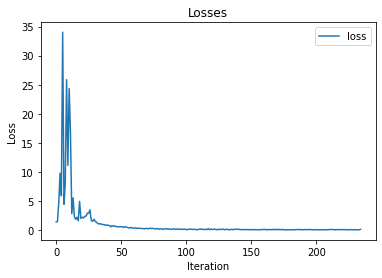

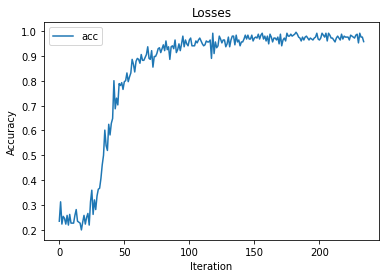

In [69]:
q2_results(q2)